In [1]:
import sys
!{sys.executable} -m pip install matplotlib pandas xlrd seaborn tqdm scikit-learn tensorflow openpyxl

    100% |████████████████████████████████| 13.0MB 946kB/s eta 0:00:01
    100% |████████████████████████████████| 10.1MB 1.2MB/s eta 0:00:01
    100% |████████████████████████████████| 112kB 29.2MB/s ta 0:00:01
    100% |████████████████████████████████| 215kB 16.2MB/s ta 0:00:01
    100% |████████████████████████████████| 51kB 17.8MB/s ta 0:00:01
    100% |████████████████████████████████| 5.4MB 3.1MB/s eta 0:00:01
    100% |████████████████████████████████| 92.6MB 142kB/s eta 0:00:01███                    | 35.1MB 86.8MB/s eta 0:00:01    65% |█████████████████████           | 60.8MB 39.2MB/s eta 0:00:01    68% |██████████████████████          | 63.9MB 52.4MB/s eta 0:00:01    82% |██████████████████████████▌     | 76.8MB 27.2MB/s eta 0:00:01ta 0:00:01
    100% |████████████████████████████████| 174kB 31.5MB/s ta 0:00:01
    100% |████████████████████████████████| 92kB 21.8MB/s ta 0:00:01
    100% |████████████████████████████████| 17.3MB 792kB/s eta 0:00:01█                   | 7.1MB

    100% |████████████████████████████████| 337kB 23.4MB/s ta 0:00:01
    100% |████████████████████████████████| 2.8MB 2.6MB/s eta 0:00:01
    100% |████████████████████████████████| 61kB 18.8MB/s ta 0:00:01
    100% |████████████████████████████████| 112kB 25.8MB/s ta 0:00:01
  Stored in directory: /home/jovyan/.cache/pip/wheels/82/cd/05/2e1db4b561fda743444f9573f2c5090a7b991200c92770dd7a
  Stored in directory: /home/jovyan/.cache/pip/wheels/ee/98/38/46cbcc5a93cfea5492d19c38562691ddb23b940176c14f7b48
  Stored in directory: /home/jovyan/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
  Stored in directory: /home/jovyan/.cache/pip/wheels/7c/06/54/bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6
  Stored in directory: /home/jovyan/.cache/pip/wheels/2a/77/35/0da0965a057698121fc7d8c5a7a9955cdbfb3cc4e2423cad39
Successfully built openpyxl absl-py gast termcolor et-xmlfile


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tqdm
import numpy as np

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, BatchNormalization, LeakyReLU, Activation, Dropout, LSTM
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.python.keras.regularizers import l2

Чтение данных из Excel

In [3]:
sales = pd.read_excel('ДанныеДекабря_2017.xlsx', 'Продажи')
sales = sales.set_index('Material')

ap = pd.read_excel('ДанныеДекабря_2017.xlsx', 'Магазины')
ap = ap.set_index('Material')

stock = pd.read_excel('ДанныеДекабря_2017.xlsx', 'Остатки')
stock = stock.set_index('Material')

price = pd.read_excel('ДанныеДекабря_2017.xlsx', 'Цены')
price = price.set_index('Material')

# hierarchy = pd.read_excel('hierarchy.xlsx')

# sell = pd.read_excel('Акции.xlsx')

Создание DataFrame для анализа зависимостей между переменными по артикулам

In [4]:
data_df = pd.melt(sales.reset_index(), id_vars=['Material'], value_vars=list(sales.columns), var_name='date', value_name='sales').sort_values(by=['Material','date'], ascending=False)
data_df = pd.merge(data_df, pd.melt(stock.reset_index(), id_vars=['Material'], value_vars=list(stock.columns), var_name='date', value_name='stock_1').sort_values(by=['Material','date'], ascending=False).shift(-1), on=['Material', 'date'])
data_df = pd.merge(data_df, pd.melt(price.reset_index(), id_vars=['Material'], value_vars=list(price.columns), var_name='date', value_name='price_1').sort_values(by=['Material','date'], ascending=False).shift(-1), on=['Material', 'date'])
data_df = pd.merge(data_df, pd.melt(ap.reset_index(), id_vars=['Material'], value_vars=list(ap.columns), var_name='date', value_name='ap_1').sort_values(by=['Material','date'], ascending=False).shift(-1), on=['Material', 'date'])
data_df.loc[:,'sales_1'] = data_df['sales'].shift(-1)
data_df.loc[:,'sales_2'] = data_df['sales_1'].shift(-1)
data_df.loc[:,'sales_3'] = data_df['sales_1'].shift(-2)
data_df.loc[:,'sales_11'] = data_df['sales_1'].shift(-10)
data_df.loc[:,'sales_12'] = data_df['sales_1'].shift(-11)
data_df.loc[:,'sales_13'] = data_df['sales_1'].shift(-12)
data_df.loc[:,'sales_cur_3_m'] = data_df['sales_1'] + data_df['sales_1'].shift(-1) + data_df['sales_1'].shift(-2)
data_df.loc[:,'sales_last_3_m'] = data_df['sales_13'] + data_df['sales_13'].shift(-1) + data_df['sales_13'].shift(-2)
data_df.loc[:,'sales_cur_y'] = data_df['sales_1'] + data_df['sales_1'].shift(-1) + data_df['sales_1'].shift(-2) + data_df['sales_1'].shift(-3) + data_df['sales_1'].shift(-4) + data_df['sales_1'].shift(-5) + data_df['sales_1'].shift(-6) + data_df['sales_1'].shift(-7) + data_df['sales_1'].shift(-8) + data_df['sales_1'].shift(-9) + data_df['sales_1'].shift(-10) + data_df['sales_1'].shift(-11)
data_df.loc[:,'sales_last_y'] = data_df['sales_13'] + data_df['sales_13'].shift(-1) + data_df['sales_13'].shift(-2) + data_df['sales_13'].shift(-3) + data_df['sales_13'].shift(-4) + data_df['sales_13'].shift(-5) + data_df['sales_13'].shift(-6) + data_df['sales_13'].shift(-7) + data_df['sales_13'].shift(-8) + data_df['sales_13'].shift(-9) + data_df['sales_13'].shift(-10) + data_df['sales_13'].shift(-11)
data_df.loc[:,'sales_trend_1'] = (data_df['sales_1'] - data_df['sales_1'].shift(-1)) / data_df['sales_1']
data_df.loc[:,'sales_trend_2'] = (data_df['sales_1'].shift(-1) - data_df['sales_1'].shift(-2)) / data_df['sales_1'].shift(-1)
data_df.loc[:,'sales_trend_ly_1'] = (data_df['sales_1'] - data_df['sales_1'].shift(-12)) / data_df['sales_1']
data_df.loc[:,'sales_trend_ly_2'] = (data_df['sales_1'].shift(-1) - data_df['sales_1'].shift(-13)) / data_df['sales_1'].shift(-1)
data_df.loc[:,'stock_2'] = data_df['stock_1'].shift(-1)
data_df.loc[:,'stock_3'] = data_df['stock_1'].shift(-2)
data_df.loc[:,'price_2'] = data_df['price_1'].shift(-1)
data_df.loc[:,'price_3'] = data_df['price_1'].shift(-2)
data_df.loc[:,'ap_2'] = data_df['ap_1'].shift(-1)

data_df = data_df.set_index('date')
    
data_df.loc[:,'month'] = data_df.index.month

data_df = data_df.replace([np.inf, -np.inf], np.nan)

data_df = data_df.dropna()

In [5]:
del sales
del ap
del stock
del price

Сохраняем собранные данные в файл для ускорения в будущем

In [5]:
data_df.to_excel('full_train_data.xlsx')

Выгружаем данные для обучения из файла

In [6]:
data_df = pd.read_excel('full_train_data.xlsx')
data_df = data_df.set_index('date')

Оценка корелляции переменных между собой

In [6]:
data_df.groupby('Material').corr().abs().sales.fillna(0).unstack(level=0).T.groupby('sales').median().T.sort_values(1.0, ascending=False).style.background_gradient(cmap='viridis')

sales,0.0,1.0
ap_1,0,0.642878
stock_1,0,0.594544
ap_2,0,0.479552
stock_2,0,0.420245
sales_1,0,0.349394
month,0,0.344816
stock_3,0,0.324693
sales_cur_3_m,0,0.316212
price_1,0,0.284989
price_2,0,0.27815


In [7]:
corr_df = data_df.groupby('Material').corr().abs().sales.fillna(0).unstack(level=0).T

#Cluster the data
kmeans = KMeans(n_clusters=5, random_state=0).fit(corr_df)
labels = kmeans.labels_

#Glue back to originaal data
corr_df['clusters'] = labels

# Создание нормализованной DF
corr_overal_df = corr_df.groupby('clusters').mean()

corr_overal_norm_df = (corr_overal_df-corr_overal_df.min())/(corr_overal_df.max()-corr_overal_df.min())

corr_overal_df.style.background_gradient(cmap='viridis')

,sales,stock_1,price_1,ap_1,sales_1,sales_2,sales_3,sales_11,sales_12,sales_13,sales_cur_3_m,sales_last_3_m,sales_cur_y,sales_last_y,sales_trend_1,sales_trend_2,sales_trend_ly_1,sales_trend_ly_2,stock_2,stock_3,price_2,price_3,ap_2,month
clusters,,,,,,,,,,,,,,,,,,,,,,,,
0,1,0.722947,0.331479,0.737363,0.531478,0.4473,0.379766,0.346504,0.369577,0.361334,0.535262,0.39812,0.419437,0.419019,0.208514,0.179802,0.340297,0.276675,0.616061,0.509581,0.300685,0.301825,0.646705,0.290625
1,1,0.724259,0.349537,0.733066,0.389055,0.264508,0.242585,0.168922,0.193009,0.105852,0.326253,0.120323,0.290144,0.152071,0.254478,0.223911,0.144613,0.12019,0.467929,0.336986,0.324672,0.315725,0.532257,0.39239
2,1,0.361019,0.240951,0.43561,0.231577,0.178495,0.175511,0.242623,0.22779,0.211245,0.208306,0.22231,0.21004,0.247033,0.172447,0.166755,0.23137,0.207528,0.246221,0.214977,0.234101,0.213996,0.277617,0.331543
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0.892592,0.824778,0.89648,0.715132,0.643283,0.56422,0.0315146,0.0278227,0.00470817,0.666579,0.00694833,0.747849,0.00846248,0.563515,0.603051,0.00452185,0.00618056,0.774442,0.702758,0.779653,0.776858,0.772252,0.748053


Создаем DF для всех материалов для обучения нейронки

In [8]:
# train_data = data_df[data_df['Material'].isin(materials_sales_list)]
train_data = data_df.merge(corr_df.clusters.to_frame(), how='left', left_on='Material', right_index=True)

Создаем тренировочные данные

In [9]:
X = train_data[[col for col in train_data.columns if col not in ['sales', 'Material']]]

Y = train_data.sales.to_frame()

scaler = MinMaxScaler()

scaler.fit(X)
scaler.fit(Y)

xscale=scaler.transform(X)
yscale=scaler.transform(Y)

X_train, X_test, y_train, y_test = train_test_split(xscale, yscale)

# # for LSTM
# X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
# X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
# y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
# y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))

# shape data for LSTM model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
# y_train = y_train.reshape((y_train.shape[0], 1, y_train.shape[1]))
# y_test = y_test.reshape((y_test.shape[0], 1, y_test.shape[1]))

/srv/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/srv/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [18]:
# # 46.8%
# model = Sequential()
# model.add(Dense(48, input_dim=24, kernel_initializer='normal'))
# model.add(Dense(64))
# model.add(Dense(24))
# model.add(Dense(1))

# model = Sequential()
# model.add(Dense(8, input_dim=24, kernel_initializer='normal'))
# model.add(Dense(4))
# model.add(Dense(2))
# model.add(Dense(1))



# # RNN
# model = Sequential()
# model.add(LSTM(32,  input_shape=(1, 23), return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=64, return_sequences=True))  
# model.add(Dropout(0.2))
# model.add(LSTM(units=64)) 
# model.add(Dropout(0.2)) 
# model.add(Dense(1))

model = Sequential()
model.add(LSTM(24,  input_shape=(24, 1), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(48))  
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation("linear"))

# Compile
model.compile(loss='mae', optimizer='adam', metrics=['mse','mae'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 24, 24)            2496      
_________________________________________________________________
dropout_4 (Dropout)          (None, 24, 24)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 48)                14016     
_________________________________________________________________
dropout_5 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 49        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 16,561
Trainable params: 16,561
Non-trainable params: 0
_________________________________________________________________


Train on 115257 samples, validate on 38420 samples
Epoch 1/20
 - 81s - loss: 0.0287 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0287 - val_loss: 0.0043 - val_mean_squared_error: 1.1933e-04 - val_mean_absolute_error: 0.0043
Epoch 2/20
 - 74s - loss: 0.0084 - mean_squared_error: 1.4899e-04 - mean_absolute_error: 0.0084 - val_loss: 0.0041 - val_mean_squared_error: 1.0612e-04 - val_mean_absolute_error: 0.0041
Epoch 3/20
 - 76s - loss: 0.0054 - mean_squared_error: 8.9063e-05 - mean_absolute_error: 0.0054 - val_loss: 0.0042 - val_mean_squared_error: 1.0515e-04 - val_mean_absolute_error: 0.0042
Epoch 4/20
 - 77s - loss: 0.0046 - mean_squared_error: 8.0283e-05 - mean_absolute_error: 0.0046 - val_loss: 0.0040 - val_mean_squared_error: 1.1115e-04 - val_mean_absolute_error: 0.0040
Epoch 5/20
 - 78s - loss: 0.0043 - mean_squared_error: 7.8255e-05 - mean_absolute_error: 0.0043 - val_loss: 0.0040 - val_mean_squared_error: 1.1123e-04 - val_mean_absolute_error: 0.0040
Epoch 6/20
 - 77s - los

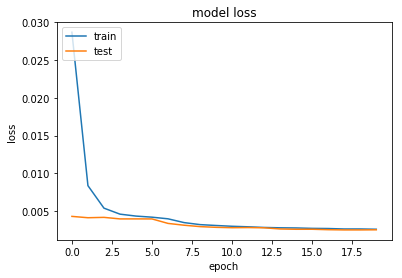

Total accuracy = 49.58%


In [19]:
history = model.fit(X_train, y_train, epochs=20, batch_size=1000, validation_data=(X_test, y_test), verbose=2)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# model.evaluate(X_test, y_test)

# Prediction
prediction = model.predict(X_test)

prediction = prediction.reshape((prediction.shape[0], 1))
test = y_test.reshape((y_test.shape[0], 1))

accuracy = 1 - sum(abs(scaler.inverse_transform(prediction) - scaler.inverse_transform(test))) / sum(scaler.inverse_transform(test))

print('Total accuracy = %.2f%%' % (accuracy * 100))

In [33]:
# Сохраним модель полностью в единый HDF5 файл

In [34]:
model.save('best_model.h5')